In [1]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

from matplotlib import animation, rc
from IPython.display import HTML

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

# Inverted Pendulum on Cart

* [Dynamics Derivation](https://en.wikipedia.org/wiki/Inverted_pendulum)

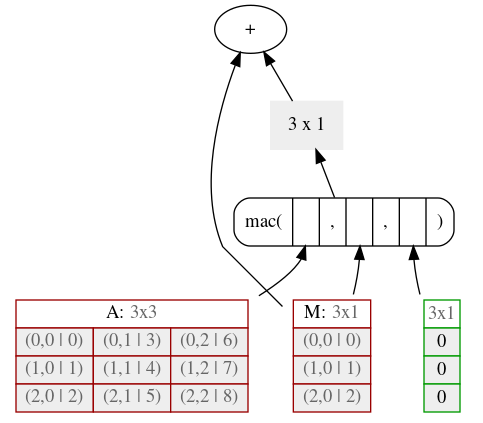

In [2]:
M = ca.MX.sym('M',3,1)
A = ca.MX.sym('A',3,3)

e1 = ca.mtimes(A,M) + M
draw_graph(e1)

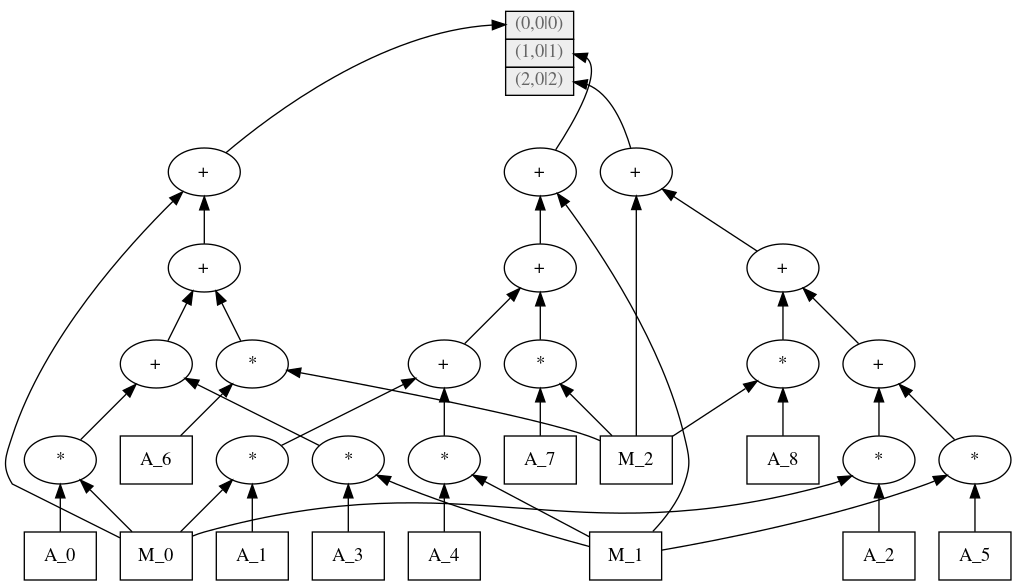

In [3]:
M = ca.SX.sym('M',3,1)
A = ca.SX.sym('A',3,3)

e1 = ca.mtimes(A,M) + M
draw_graph(e1)

In [4]:
f_SX = ca.Function('test', [A,M],[e1])
import numpy as np
f_SX(np.eye(3), [1,2,3])

DM([2, 4, 6])

In [5]:
ca.jacobian(e1,M);

In [6]:
def inv_pend_cart_ode():
    """
    Defines and ordinary differential equation for an inverted pendulum on a cart.
    """
    
    M = ca.MX.sym('M')  # cart mass
    m = ca.MX.sym('m')  # pendulum mass
    g = ca.MX.sym('g')  # accel of gravity
    l = ca.MX.sym('l')  # length of pendulum
    u = ca.MX.sym('u')  # input force
    
    # cart position and derivatives
    x = ca.MX.sym('x')  
    xd = ca.MX.sym('xd')
    xdd = ca.MX.sym('xdd')

    # pendulum angle and derivatives
    theta = ca.MX.sym('theta')
    thetad = ca.MX.sym('thetad')
    thetadd = ca.MX.sym('thetadd')

    # equations of motion as given in wiki link above
    eq1 = (M + m)*xdd - m*l*thetadd*ca.cos(theta) + m*l*thetad**2*ca.sin(theta) - u
    eq2 = l*thetadd - g*ca.sin(theta) - xdd*ca.cos(theta)
    eq_list = ca.vertcat(eq1, eq2)
    
    # this is a nonlinear system of equations, but we can solve for xdd, and thetadd using the jacobian, which is exact
    # since xdd and thetadd only appear linearly
    A = ca.jacobian(eq_list, ca.vertcat(thetadd, xdd))
    b = ca.substitute(eq_list, ca.vertcat(thetadd, xdd), ca.vertcat(0, 0))
    sol = ca.solve(A, b)
    ode = {}
    x = ca.vertcat(theta, thetad, x, xd)
    p = ca.vertcat(m, M, l, g, u)
    rhs = ca.vertcat(thetad, sol[0], xd, sol[1]) # xdot vector
    ode['x'] = x  # state
    ode['p'] = p # parameters
    ode['ode'] = rhs  # right hand side X-dot
    rhs = ca.Function('rhs', [x, p], [rhs], ['x', 'p'], ['rhs'])
    return ode, rhs

In [7]:
def simulate_ode(ode, x0, f_p=None, t0=0, tf=10, dt=0.01):
    """
    Simulates an ordinary differential equation.
    
    Paramers:
    ode: A dictionary describing the ode in the Casadi format.
    x0: Initial state.
    f_p: A function of time and state that generates the parameters f_p(t, x)
    t0: Initial time.
    tf: Final time.
    dt: The time-step for discrete updates and recording data.
    
    Return:
    data: A dictionary with keys for time: 't', and state: 'x'
    """
    t_vect = np.arange(t0, tf, dt)
    data = {
        't': [],
        'x': []
    }
    x = np.array(x0).reshape(-1)
    for t in t_vect:
        sim = ca.integrator('integrator', 'cvodes', ode, {'t0': t, 'tf': t + dt})
        res = sim(x0=x, p=f_p(t, x))
        x = np.array(res['xf']).reshape(-1)
        data['t'].append(t)
        data['x'].append(x)

    for k in data.keys():
        data[k] = np.array(data[k])
    return data

In [8]:
def inv_pend_cart_anim(data, xmin=-1, xmax=4):
    """
    Creates a simple animation of an inverted pendulum on a cart.
    """
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.gca()

    ax.set_xlim((xmin, xmax))
    ax.set_ylim((-1.5, 1.5))

    line, = ax.plot([], [], lw=2)
    circle = patches.Circle((0, 0), 0.1, fc='none', ec='k')
    rect = patches.Rectangle((-0.5, 0), 0.2, 0.2, fc='none', ec='k')
    ax.add_artist(circle)
    ax.add_artist(rect)

    # initialization function: plot the background of each frame
    def init():
        return (line, circle, rect,)

    # animation function. This is called sequentially
    def animate(i):
        j = int(len(data['t'])/100*i)
        theta = data['x'][j, 0]
        x = data['x'][j, 2]
        rect.set_xy((x - 0.1, -0.1))
        line.set_data([[x, x - np.sin(theta)], [0, -np.cos(theta)]])
        circle.set_center((x - np.sin(theta), -np.cos(theta)))
        return (line,)

    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=100, interval=100, blit=True)
    plt.close()
    return anim

In [10]:
ode, rhs = inv_pend_cart_ode()
print(ode)
data = simulate_ode(ode=ode, x0=(3.14, 0, 0, 0), f_p=lambda t, x: (1, 2, 1, 9.8, 0))
anim = inv_pend_cart_anim(data)
HTML(anim.to_html5_video())

{'x': MX(vertcat(theta, thetad, x, xd)), 'p': MX(vertcat(m, M, l, g, u)), 'ode': MX(@1=vertsplit(ones(2x1,1nz)){0}, @2=vertsplit(ones(2x1,1nz)){1}, @3=(((zeros(2x2)[:4:2] = vertcat((-(cos(theta)*((m*l)*@1))), (l*@1)))[1:5:2] = vertcat(((M+m)*@2), (-(cos(theta)*@2))))'\vertcat(((((m*l)*sq(thetad))*sin(theta))-u), (-(g*sin(theta))))), vertcat(thetad, @3[0], xd, @3[1]))}


# Designing a Stand Maneuver with Casadi

This is a straight-forward approach to designing a control input to perform a maneuver with a fixed number of steps. A better approach here would be to design instead the switching time of the input direction, with the magnitude fixed. This doesn't allow the use of the CVODES solver, since the time duration itself is the input. Switching to the rk integration method should allow this approach for the interested reader.

In [11]:
def find_stand_maneuver(n_steps=5, total_time=4):
    ode, rhs = inv_pend_cart_ode()
    t = ca.MX.sym('t')
    dt = total_time/n_steps
    t_vect = np.arange(0, total_time, dt)
    F = ca.integrator('integrator', 'cvodes', ode, {'tf': dt})

    x0 = ca.vertcat(0, 0, 0, 0)
    xf = ca.vertcat(np.pi, 0, 0, 0)

    m = ca.MX.sym('m')
    M = ca.MX.sym('M')
    l = ca.MX.sym('l')
    g = ca.MX.sym('g')

    x = x0
    u = ca.MX.sym('u', n_steps)

    for i in range(n_steps):
        res = F(x0=x, p=ca.vertcat(m, M, l, g, u[i]))
        x = res['xf']
    #dx = rhs(x, ca.vertcat(m, M, l, g, 0))
    
    constraint = ca.dot(x - xf, x - xf)
    nlp = {'x':u,'f':ca.dot(u,u),'g':constraint, 'p': ca.vertcat(m, M, l, g)}

    # Solve using IPOPT
    solver = ca.nlpsol('solver', 'ipopt', nlp, {
        'print_time': 1,
        'ipopt': {
            'sb': 'yes',
            'print_level': 2,
            'max_iter': 500,
        }
    })
    res = solver(x0=0, p=(1, 2, 1, 9.8), lbg=0, ubg=0)
    u_vect = np.array(res['x']).reshape(-1).tolist()
    u_vect.append(0)
    t_vect = np.array(t_vect).reshape(-1).tolist()
    t_vect.append(t_vect[-1] + dt)
    return u_vect, t_vect

u_vect, t_vect = find_stand_maneuver()

               t_proc [s]   t_wall [s]    n_eval
       nlp_f      0.00284      0.00273      1082
       nlp_g         6.02         5.98      1101
    nlp_grad       0.0401       0.0399         1
  nlp_grad_f      0.00181      0.00174       476
  nlp_hess_l         91.1         90.6       498
   nlp_jac_g         9.37         9.31       505
      solver          107          106         1


At t = 0.724614, mxstep steps taken before reaching tout.
CasADi - 2019-09-09 15:24:22 WARNING("solver:nlp_g failed:Error in Function::operator() for 'nlp_g' [MXFunction] at .../casadi/core/function.cpp:1255:
Error in Function::operator() for 'integrator' [CvodesInterface] at .../casadi/core/function.cpp:1255:
.../casadi/interfaces/sundials/cvodes_interface.cpp:379: CVode returned "CV_TOO_MUCH_WORK". Consult CVODES documentation.") [.../casadi/core/oracle_function.cpp:208]


In [12]:
def create_piecewise(t_vect, u_vect):
    # create function
    t = ca.MX.sym('t')
    expr = u_vect[-1]
    n = len(t_vect)
    for i in range(n-1, -1, -1):
        expr = ca.if_else(t < t_vect[i], u_vect[i - 1], expr)
    expr = ca.if_else(t < 0, 0, expr)
    f_stand = ca.Function('u', [t], [expr], ['t'], ['u'])
    return f_stand

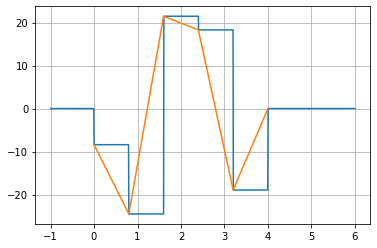

In [13]:
f_stand = create_piecewise(t_vect, u_vect)
t = np.linspace(-1, 6, 1000)
plt.plot(t, f_stand(t))
plt.plot(t_vect, u_vect)
plt.grid()

In [14]:
data_stand = simulate_ode(ode=ode, x0=(0, 0, 0, 0), f_p=lambda t, x: ca.vertcat(1, 2, 9.8, 1, f_stand(t)), tf=4)
anim_stand = inv_pend_cart_anim(data_stand, xmin=0, xmax=40)
HTML(anim_stand.to_html5_video())

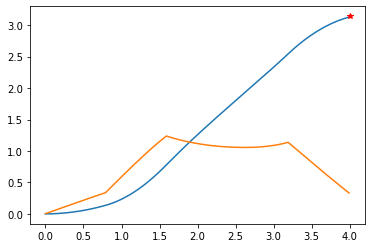

In [15]:
plt.plot(data_stand['t'], data_stand['x'][:, 0], label='theta')
plt.plot(data_stand['t'], data_stand['x'][:, 1], label='thetad')

plt.plot([4], [np.pi], 'r*')